In [1]:
using Pkg
Pkg.activate(".")

  Activating project at `~/Desktop/PhD_Stuff/cheb_bessel_tests-main`


In [2]:
using BenchmarkTools
using LinearAlgebra
using DataInterpolations
using SpecialFunctions
using HCubature
using QuadGK
using Polynomials
using Plots
using FastChebInterp
using ProgressBars
using LaTeXStrings
using Bessels
using Tullio
using FFTW
using LoopVectorization
using NPZ
using Cubature
using FastTransforms
using Interpolations
using Dierckx
using DelimitedFiles
using TwoFAST

In [3]:
using Revise
using Will

### Adapting N5K stuff

In [4]:
z_b = npzread("background/z.npy")
χ = npzread("background/chi.npy")
z_of_χ = DataInterpolations.AkimaInterpolation(z_b, χ);

In [5]:
pk_dict = npzread("../N5K/input/pk.npz")
Pklin = pk_dict["pk_lin"]
k = pk_dict["k"]
z = pk_dict["z"];

In [6]:
y = LinRange(log10(first(k)),log10(last(k)), length(k))
x = LinRange(first(z), last(z), length(z))
InterpPmm = Interpolations.interpolate(log10.(Pklin),BSpline(Cubic(Line(OnGrid()))))
InterpPmm = scale(InterpPmm, x, y)
InterpPmm = Interpolations.extrapolate(InterpPmm, Line());

In [7]:
power_spectrum(k, χ1, χ2) = @. sqrt(10^InterpPmm(z_of_χ(χ1),log10(k)) * 10^InterpPmm(z_of_χ(χ2),log10(k)));

#### Utilities

In [8]:
function plot_pmd(w, i, label,ell_list="ell_vector.npy")
    ell_vector = sort!(npzread("ell_vector.npy"))
    ℓ = round(ell_vector[i], digits=1)
    p = heatmap(log10.(abs.(w[i,:,:]./maximum(w[i,:,:]))), aspect_ratio=1, size=[500,440], xlabel=L"\chi [Mpc]", ylabel=L"\chi [Mpc]", title="Projected Matter density, ℓ=$(ℓ), $label")
    return plot(p, layout=(1,1))
end;

In [9]:
function load_Ts(folder, nχ, nR)
    ell_vector = sort!(npzread("ell_vector.npy")) 
    full_T = zeros(26, nχ, nR, 129)
    for i in 1:26
        l_string = string(round(ell_vector[i]; digits=1))
        filename = folder * "/T_tilde_l_$l_string.npy"
        full_T[i,:,:,:] = npzread(filename)
    end
    return full_T
end;

In [10]:
function SimpsonWeightArray(n)
    number_intervals = floor((n-1)/2)
    weight_array = zeros(n)
    if n == number_intervals*2+1
        for i in 1:number_intervals
            weight_array[Int((i-1)*2+1)] += 1/3
            weight_array[Int((i-1)*2+2)] += 4/3
            weight_array[Int((i-1)*2+3)] += 1/3
        end
    else
        weight_array[1] += 0.5
        weight_array[2] += 0.5
        for i in 1:number_intervals
            weight_array[Int((i-1)*2+1)+1] += 1/3
            weight_array[Int((i-1)*2+2)+1] += 4/3
            weight_array[Int((i-1)*2+3)+1] += 1/3
        end
        weight_array[length(weight_array)]   += 0.5
        weight_array[length(weight_array)-1] += 0.5
        for i in 1:number_intervals
            weight_array[Int((i-1)*2+1)] += 1/3
            weight_array[Int((i-1)*2+2)] += 4/3
            weight_array[Int((i-1)*2+3)] += 1/3
        end
        weight_array ./= 2
    end
    return weight_array
end;

In [11]:
function compute_kernel(nχ, nR, label)
    W = npzread("../N5K/input/kernels_fullwidth.npz")

    χ = LinRange(26,7000,nχ)
    R = LinRange(0,1, nR)

    if label == "CL"
        WA = W["kernels_sh"]
        WB = W["kernels_cl"]
        nbinsA = 5
        nbinsB = 10
    elseif label == "CC"
        WA = W["kernels_cl"]
        WB = WA
        nbinsA = 10
        nbinsB = 10
    elseif label == "LL"
        WA = W["kernels_sh"]
        WB = WA
        nbinsA = 5
        nbinsB = 5
    end
    WA_interp_χ = zeros(nbinsA,nχ)
    WB_interp_χ = zeros(nbinsB,nχ)

    #interpolo i kernel su χ once for all
    for i in 1:nbinsA
        interp = BSplineInterpolation(WA[i,:], W["chi_sh"], 3, :ArcLen, :Average, extrapolate=true)
        WA_interp_χ[i,:] = interp.(χ)
    end

    for i in 1:nbinsB
        interp = BSplineInterpolation(WB[i,:], W["chi_sh"], 3, :ArcLen, :Average, extrapolate=true)
        WA_interp_χ[i,:] = interp.(χ)
    end

    K = zeros(nbinsA, nbinsB, nχ, nR)

    for (ridx,r) in enumerate(R)
        println("Processing R = $r")
    
        WA_interp_R = zeros(nbinsA,nχ)
        WB_interp_R = zeros(nbinsB,nχ)
    
        for k in 1:nbinsA
            interp = BSplineInterpolation(WA[k,:], W["chi_sh"], 3, :ArcLen, :Average, extrapolate=true)
            for i in 1:nχ
                WA_interp_R[k,i] = interp(r*χ[i])
            end
        end
    
        for k in 1:nbinsB
            interp = BSplineInterpolation(WB[k,:], W["chi_sh"], 3, :ArcLen, :Average, extrapolate=true)
            for i in 1:nχ
                WB_interp_R[k,i] = interp(r*χ[i])
            end
        end
    
        if label == "CL"
            for i in 1:nbinsA
                WA_interp_χ[i,:] = WA_interp_χ[i,:] ./ (Array(χ) .^ 2)
                WA_interp_R[i,:] = WA_interp_R[i,:] ./ (Array(r*χ) .^ 2)
            end
        elseif label == "LL"
            for i in 1:nbinsA
                WA_interp_χ[i,:] = WA_interp_χ[i,:] ./ (Array(χ) .^ 2)
                WA_interp_R[i,:] = WA_interp_R[i,:] ./ (Array(r*χ) .^ 2)
            end
            for i in 1:nbinsB
                WB_interp_χ[i,:] = WB_interp_χ[i,:] ./ (Array(χ) .^ 2)
                WB_interp_R[i,:] = WB_interp_R[i,:] ./ (Array(r*χ) .^ 2)
            end
        end
    
        #K[i,j,h,ridx]
        @tullio K_app[i,j,h] := WA_interp_χ[i,h]*WB_interp_R[j,h]+WB_interp_χ[j,h]*WA_interp_R[i,h]

        K[:,:,:,ridx] = K_app

    end

    return K
end

compute_kernel (generic function with 1 method)

In [12]:
function C_ell_computation_simpson(w, K) #qui passo i kernel in purezza, non interpolati
    
    nχ = length(w[1,:,1])
    nR = length(w[1,1,:])

    χ = LinRange(26,7000,nχ)
    R = LinRange(0,1, nR)

    Δχ = ((last(χ)-first(χ))/(nχ-1))
    pesi_χ = SimpsonWeightArray(nχ)
    ΔR = ((last(R)-first(R))/(nR-1))
    pesi_R = SimpsonWeightArray(nR)
        
    @tullio Cℓ[l,i,j] := χ[n]*K[i,j,n,m]*w[l,n,m]*pesi_χ[n]*pesi_R[m]*Δχ*ΔR
    
    return Cℓ
    
end;

In [13]:
function w_2F_interp(χ1, label, ℓ)
    N = 30000
    kmin = 1e-5
    kmax = 1e7
    chi0 = 0.00001 
    ell = [Int(ℓ)] 
    #RR = [1.0]

    if label == "LL"
        q = -2.1
        idx = 4
    elseif label == "CL"
        q = 0.5
        idx = 2
    elseif label == "CC"
        q = 1.1
        idx = 0
    end

    Rs = LinRange(0,1,100)

    w_cR = zeros(length(χ1), length(χ1))
    
    for (rindex, r) in enumerate(Rs)
        println("Processing R = $r")
        RR = [r]
        f21cache = F21EllCache(maximum(ell), RR, N; q=q, kmin=kmin, kmax=kmax, χ0=chi0)
        write("out/F21EllCache", f21cache)
            
        # calculate all M_ll, result gets saved to a file:
        mlcache = MlCache(ell, "out/F21EllCache", "out/MlCache")
        write("out/MlCache", mlcache)
        for i in 1:length(χ1)
            # calculate wljj:
            w00 = Array{Float64}(undef, N, length(RR))
            function outfunc(wjj, ell, rr, RR)
                w00[:,:] = wjj[1]
            end
            rr = calcwljj(x->power_spectrum(x, χ1[i], r*χ1[i])/x^(idx), RR; ell=ell, kmin=kmin, kmax=kmax, N=N, r0=chi0, q=q, outfunc=outfunc, cachefile="out/MlCache/MlCache.bin")
            interp= Spline1D(rr, w00[:,1])
            w00_interp = interp.(χ1)*π/2
            w_cR[i,rindex] = w00_interp[i]
        end
    end
        
    return w_cR
end

w_2F_interp (generic function with 1 method)

### Loading N5K stuff

In [14]:
#N5K Cℓ's 
benchmark_gg = npzread("../N5K/tests/benchmarks_nl_full_clgg.npz")
benchmark_ll = npzread("../N5K/tests/benchmarks_nl_full_clss.npz")
benchmark_gl = npzread("../N5K/tests/benchmarks_nl_full_clgs.npz");

In [15]:
gg = benchmark_gg["cls"]
ll = benchmark_ll["cls"]
gl = benchmark_gl["cls"]
ell = benchmark_gg["ls"];

In [16]:
gg_reshaped = zeros(length(ell), 10, 10)
counter = 1

for i in 1:10
    for j in i:10
        gg_reshaped[:,i,j] = gg[counter, :]
        gg_reshaped[:,j,i] = gg_reshaped[:,i,j]
        counter += 1
    end
end

In [17]:
ll_reshaped = zeros(length(ell), 5, 5)
counter = 1

for i in 1:5
    for j in i:5
        ll_reshaped[:,i,j] = ll[counter, :]
        ll_reshaped[:,j,i] = ll_reshaped[:,i,j]
        counter += 1
    end
end

In [18]:
gl_reshaped = zeros(length(ell), 10, 5)
counter = 1

for i in 1:10
    for j in i:5
        gl_reshaped[:,i,j] = gl[counter, :]
        gl_reshaped[:,j,i] = gl_reshaped[:,i,j]
        counter += 1
    end
end

### Loading my $w_\ell$'s

In [19]:
kmax = 200/13 
kmin = 2.5/7000
n_cheb = 128
nχ = 100
nR = 100
χ = LinRange(26, 7000, nχ)
Rs = LinRange(0,1, nR)
ℓ = sort!(npzread("ell_vector.npy"))

k_cheb = chebpoints(n_cheb, log10(kmin), log10(kmax));
coeff = zeros(nχ,nR,n_cheb+1)

for i in 1:nR
    for j in 1:nχ
        c = chebinterp(power_spectrum.(10 .^ k_cheb,χ[j],χ[j]*Rs[i]), log10(kmin), log10(kmax)); #the bug was probably here, i wasn't doing 10^k_cheb
        coeff[j,i,:] = c.coefs
    end
end;

In [20]:
#T_LL = load_Ts("T_tilde_LL", nχ, nR)
T_CL = load_Ts("T_tilde_CL", nχ, nR)
T_CC = load_Ts("T_tilde_CC", nχ, nR)

#w_LL = Will.w_ell_tullio(coeff, T_LL)
w_CL = Will.w_ell_tullio(coeff, T_CL)
w_CC = Will.w_ell_tullio(coeff, T_CC);

In [21]:
ℓ_2F = [20,100,200,300]
function load_w_2F(label)
    ell_list = [20, 100, 200,300]
    w = zeros(4, 100, 100)
    for (lidx, l) in enumerate(ell_list)
        filename = "w_2_FAST/w_$(label)_l_$l.npz"
        w[lidx,:,:] = npzread(filename)
    end
    return w
end;

In [23]:
w_CC_2F = load_w_2F("CC")
w_CL_2F = load_w_2F("CL");

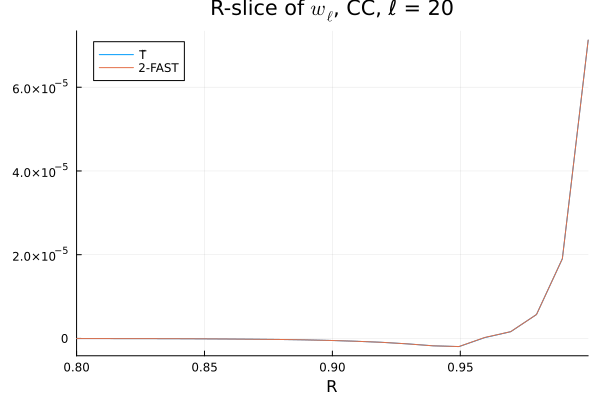

In [24]:
plot(Rs, w_CC[6,50,:], xlim=(0.8,1), label="T̃", title = L"R-slice of $w_\ell$, CC, ℓ = 20", xlabel = "R")
plot!(Rs, w_CC_2F[1,50,:], label="2-FAST")

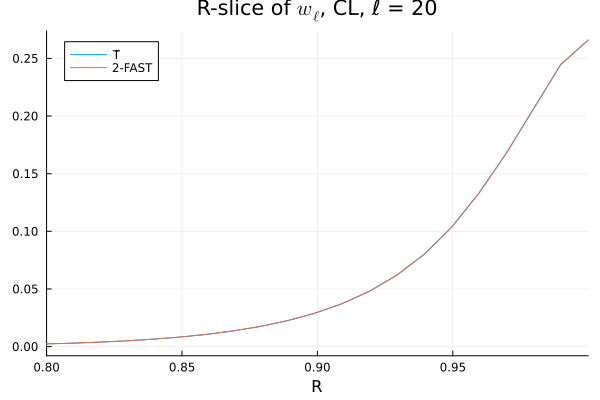

In [36]:
plot(Rs, w_CL[6,50,:], xlim=(0.8,1), label="T̃", title = L"R-slice of $w_\ell$, CL, ℓ = 20", xlabel = "R")
plot!(Rs, w_CL_2F[1,50,:], label="2-FAST")

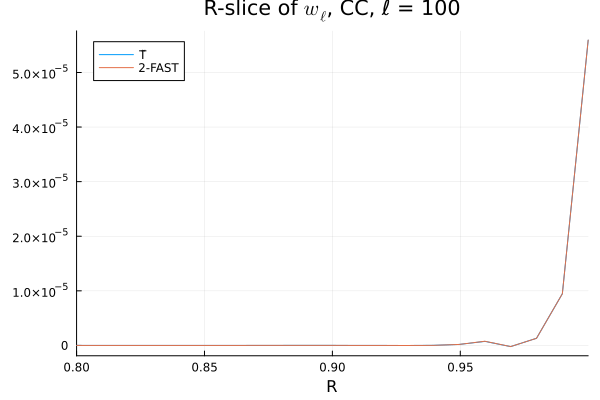

In [25]:
plot(Rs, w_CC[15,50,:], xlim=(0.8,1), label="T̃", title = L"R-slice of $w_\ell$, CC, ℓ = 100", xlabel = "R")
plot!(Rs, w_CC_2F[2,50,:], label="2-FAST")

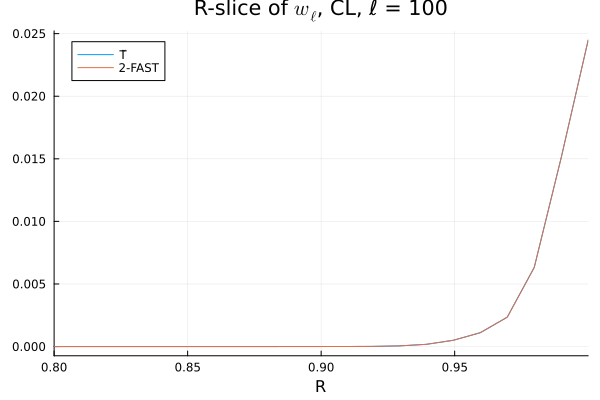

In [37]:
plot(Rs, w_CL[15,50,:], xlim=(0.8,1), label="T̃", title = L"R-slice of $w_\ell$, CL, ℓ = 100", xlabel = "R")
plot!(Rs, w_CL_2F[2,50,:], label="2-FAST")

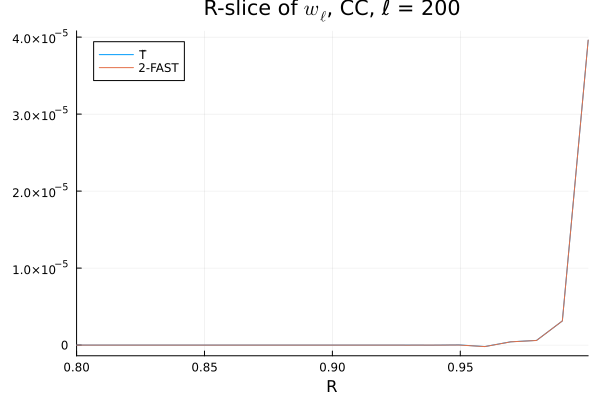

In [26]:
plot(Rs, w_CC[21,50,:], xlim=(0.8,1), label="T̃", title = L"R-slice of $w_\ell$, CC, ℓ = 200", xlabel = "R")
plot!(Rs, w_CC_2F[3,50,:], label="2-FAST")

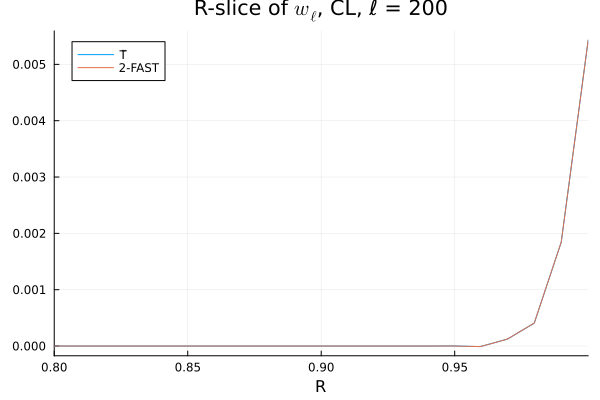

In [38]:
plot(Rs, w_CL[21,50,:], xlim=(0.8,1), label="T̃", title = L"R-slice of $w_\ell$, CL, ℓ = 200", xlabel = "R")
plot!(Rs, w_CL_2F[3,50,:], label="2-FAST")

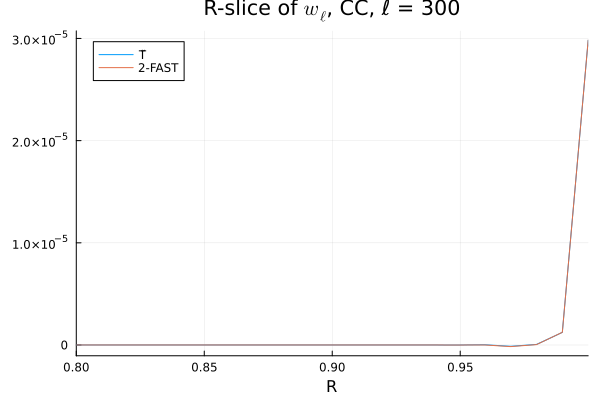

In [27]:
plot(Rs, w_CC[26,50,:], xlim=(0.8,1), label="T̃", title = L"R-slice of $w_\ell$, CC, ℓ = 300", xlabel = "R")
plot!(Rs, w_CC_2F[4,50,:], label="2-FAST")

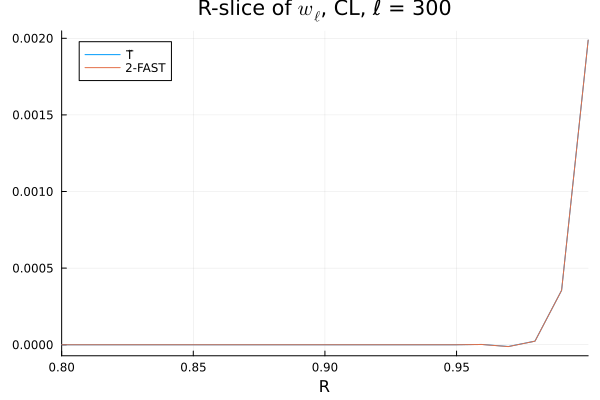

In [39]:
plot(Rs, w_CL[26,50,:], xlim=(0.8,1), label="T̃", title = L"R-slice of $w_\ell$, CL, ℓ = 300", xlabel = "R")
plot!(Rs, w_CL_2F[4,50,:], label="2-FAST")

# $C_\ell$'s computation

In [28]:
@time K_CC = compute_kernel(nχ, nR, "CC")
#@time K_CL = compute_kernel(nχ, nR, "CL");

Processing R = 0.0
Processing R = 0.010101010101010102
Processing R = 0.020202020202020204
Processing R = 0.030303030303030304
Processing R = 0.04040404040404041
Processing R = 0.050505050505050504
Processing R = 0.06060606060606061
Processing R = 0.0707070707070707
Processing R = 0.08080808080808081
Processing R = 0.09090909090909091
Processing R = 0.10101010101010101
Processing R = 0.1111111111111111
Processing R = 0.12121212121212122
Processing R = 0.13131313131313133
Processing R = 0.1414141414141414
Processing R = 0.15151515151515152
Processing R = 0.16161616161616163
Processing R = 0.1717171717171717
Processing R = 0.18181818181818182
Processing R = 0.1919191919191919
Processing R = 0.20202020202020202
Processing R = 0.21212121212121213
Processing R = 0.2222222222222222
Processing R = 0.23232323232323232
Processing R = 0.24242424242424243
Processing R = 0.25252525252525254
Processing R = 0.26262626262626265
Processing R = 0.2727272727272727
Processing R = 0.2828282828282828
Proce

LoadError: BoundsError: attempt to access 5×100 Matrix{Float64} at index [6, 1:100]

In [32]:
Cℓ_CC = C_ell_computation_simpson(w_CC, K_CC);
#Cℓ_LL = C_ell_computation_simpson(w_LL, "LL");
#Cℓ_CL = C_ell_computation_simpson(w_CL, K_CL);

In [33]:
Cℓ_CC_2F = C_ell_computation_simpson(w_CC_2F, K_CC);
#Cℓ_CL_2F = C_ell_computation_simpson(w_CL_2F, K_CL);

In [34]:
# ADDING ELL PREFACTORS
Cℓ_CC = Cℓ_CC .* (2/π)
Cℓ_CC_2F = Cℓ_CC_2F .* (2/π)

function factorial_frac(n)
    return (n-1)*n*(n+1)*(n+2)
end

for i in 1:length(ℓ)
    #Cℓ_LL[i,:,:] = Cℓ_LL[i,:,:] .* 2 .* factorial_frac(ℓ[i]) ./ π
    #Cℓ_CL[i,:,:] = Cℓ_CL[i,:,:] .* 2 .* sqrt.(factorial_frac(ℓ[i])) ./ π
end

for i in 1:length(ℓ_2F)
    #Cℓ_LL[i,:,:] = Cℓ_LL[i,:,:] .* 2 .* factorial_frac(ℓ[i]) ./ π
    #Cℓ_CL_2F[i,:,:] = Cℓ_CL_2F[i,:,:] .* 2 .* sqrt.(factorial_frac(ℓ_2F[i])) ./ π
end

# Plots

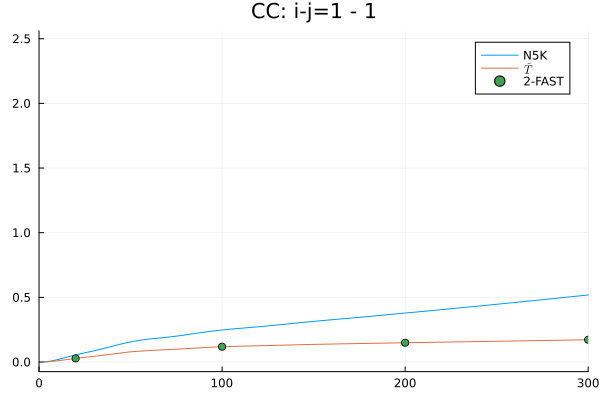

In [35]:
i = 1
j = 1
plot(ell, gg_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "CC: i-j=$i - $j", label="N5K", xlim=(0,300))
plot!(ℓ, Cℓ_CC[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$")
scatter!(ℓ_2F, Cℓ_CC_2F[:,i,j] .* ℓ_2F .* (ℓ_2F .+ 1) , label = "2-FAST")

In [ ]:
i = 2
j = 4
plot(ell, ll_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "LL: : i-j=$i - $j", label="N5K", xlim=(0,300), yscale=:log10)
plot!(ℓ, Cℓ_LL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$",legend=:bottomright)

In [ ]:
i = 5
j = 5
plot(ell, gl_reshaped[:,i,j] .* ell .* (ell .+ 1), title = "CL: : i-j=$i - $j", label="N5K", xlim=(0,300))
plot!(ℓ, Cℓ_CL[:,i,j] .* ℓ .* (ℓ .+ 1) , label = L"$\tilde T$", legend=:bottomright)